# End-to-End Data Cleaning Pipeline with Raha and Baran (Minimal and Sequential)
We build an end-to-end data cleaning pipeline with our configuration-free error detection and correction systems, Raha and Baran.

In [1]:
import pandas
import IPython.display
from pandas import DataFrame, Series
import pickle
import raha
import numpy as np
import matplotlib.pyplot as plt

## Error Detection with Raha

### 1. Instantiating the Detection Class
We first instantiate the `Detection` class.

In [2]:
app_1 = raha.Detection()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20

# Would you like to see the logs?
app_1.VERBOSE = True

### 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [3]:
dataset_dictionary = {
    "name": "flights",
    "path": "datasets/flights/dirty.csv",
    "clean_path": "datasets/flights/clean.csv"
}
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


### 3. Running Error Detection Strategies
Raha runs (all or the promising) error detection strategies on the dataset. This step could take a while because all the strategies should be run on the dataset. 

In [4]:
app_1.run_strategies(d)

309 strategy profiles are collected.


I just load strategies' results as they have already been run on the dataset!


### 4. Generating Features
Raha then generates a feature vector for each data cell based on the output of error detection strategies. 

In [5]:
app_1.generate_features(d)

40 Features are generated for column 0.
65 Features are generated for column 1.
62 Features are generated for column 2.
65 Features are generated for column 3.
71 Features are generated for column 4.
65 Features are generated for column 5.
86 Features are generated for column 6.


### 5. Building Clusters
Raha next builds a hierarchical clustering model for our clustering-based sampling approach.

In [6]:
app_1.build_clusters(d)

A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for column 2.
A hierarchical clustering model is built for column 3.
A hierarchical clustering model is built for column 4.
A hierarchical clustering model is built for column 5.
A hierarchical clustering model is built for column 6.


### 6. Interactive Tuple Sampling and Labeling
Raha then iteratively samples a tuple. We should label data cells of each sampled tuple.

In [7]:
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)
    else:
        print("Label the dirty cells in the following sampled tuple.")
        sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
        IPython.display.display(sampled_tuple)
        for j in range(d.dataframe.shape[1]):
            cell = (d.sampled_tuple, j)
            value = d.dataframe.iloc[cell]
            correction = input("What is the correction for value '{}'? Type in the same value if it is not erronous.\n".format(value))
            user_label = 1 if value != correction else 0
            d.labeled_cells[cell] = [user_label, correction]
        d.labeled_tuples[d.sampled_tuple] = 1

Tuple 39 is sampled.
Tuple 39 is labeled.
Tuple 1939 is sampled.
Tuple 1939 is labeled.
Tuple 222 is sampled.
Tuple 222 is labeled.
Tuple 2016 is sampled.
Tuple 2016 is labeled.
Tuple 943 is sampled.
Tuple 943 is labeled.
Tuple 1619 is sampled.
Tuple 1619 is labeled.
Tuple 262 is sampled.
Tuple 262 is labeled.
Tuple 1035 is sampled.
Tuple 1035 is labeled.
Tuple 688 is sampled.
Tuple 688 is labeled.
Tuple 572 is sampled.
Tuple 572 is labeled.
Tuple 1409 is sampled.
Tuple 1409 is labeled.
Tuple 1099 is sampled.
Tuple 1099 is labeled.
Tuple 708 is sampled.
Tuple 708 is labeled.
Tuple 1042 is sampled.
Tuple 1042 is labeled.
Tuple 1498 is sampled.
Tuple 1498 is labeled.
Tuple 1685 is sampled.
Tuple 1685 is labeled.
Tuple 2152 is sampled.
Tuple 2152 is labeled.
Tuple 241 is sampled.
Tuple 241 is labeled.
Tuple 1729 is sampled.
Tuple 1729 is labeled.
Tuple 290 is sampled.
Tuple 290 is labeled.


### 7. Propagating User Labels
Raha then propagates each user label through its cluster.

In [8]:
app_1.propagate_labels(d)

The number of labeled data cells increased from 140 to 12307.


### 8. Predicting Labels of Data Cells
Raha then trains and applies one classifier per data column to predict the label of the rest of data cells.

In [9]:
app_1.predict_labels(d)

A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.


### 9. Storing Results
Raha can also store the error detection results.

In [10]:
app_1.store_results(d)

The results are stored in datasets/flights/raha-baran-results-flights/error-detection/detection.dataset.


### 10. Evaluating the Error Detection Task
We can finally evaluate our error detection task.

In [11]:
p, r, f = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
print("Raha's performance on {}:\nPrecision = {:.2f}\nRecall = {:.2f}\nF1 = {:.2f}".format(d.name, p, r, f))

Raha's performance on flights:
Precision = 0.70
Recall = 0.82
F1 = 0.76


/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


# Error Correction with Baran

### 1. Instantiating the Correction Class
We first instantiate the `Correction` class.

In [12]:
app_2 = raha.Correction()

# How many tuples would you label?
app_2.LABELING_BUDGET = 20

# Would you like to see the logs?
app_2.VERBOSE = True

### 2. Initializing the Dataset Object
We next initialize the dataset object.

In [13]:
d = app_2.initialize_dataset(d)
d.dataframe.head()

,tuple_id,src,flight,sched_dep_time,act_dep_time,sched_arr_time,act_arr_time
0,1,aa,AA-3859-IAH-ORD,7:10 a.m.,7:16 a.m.,9:40 a.m.,9:32 a.m.
1,2,aa,AA-1733-ORD-PHX,7:45 p.m.,7:58 p.m.,10:30 p.m.,
2,3,aa,AA-1640-MIA-MCO,6:30 p.m.,,7:25 p.m.,
3,4,aa,AA-518-MIA-JFK,6:40 a.m.,6:54 a.m.,9:25 a.m.,9:28 a.m.
4,5,aa,AA-3756-ORD-SLC,12:15 p.m.,12:41 p.m.,2:45 p.m.,2:50 p.m.


### 3. Initializing the Error Corrector Models
Baran initializes the error corrector models.

In [14]:
app_2.initialize_models(d)

The error corrector models are initialized.


### 4. Interactive Tuple Sampling, Labeling, Model updating, Feature Generation, and Correction Prediction
Baran then iteratively samples a tuple. We should label data cells of each sampled tuple. It then udpates the models accordingly and generates a feature vector for each pair of a data error and a correction candidate. Finally, it trains and applies a classifier to each data column to predict the final correction of each data error. Since we already labeled tuples for Raha, we use the same labeled tuples and do not label new tuples here.

In [15]:
# while len(d.labeled_tuples) < app_2.LABELING_BUDGET:
#     app_2.sample_tuple(d)
#     if d.has_ground_truth:
#         app_2.label_with_ground_truth(d)
#     else:
#         print("Label the dirty cells in the following sampled tuple.")
#         sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
#         IPython.display.display(sampled_tuple)
#         for j in range(d.dataframe.shape[1]):
#             cell = (d.sampled_tuple, j)
#             value = d.dataframe.iloc[cell]
#             correction = input("What is the correction for value '{}'? Type in the same value if it is not erronous.\n".format(value))
#             user_label = 1 if value != correction else 0
#             d.labeled_cells[cell] = [user_label, correction]
#         d.labeled_tuples[d.sampled_tuple] = 1
#     app_2.update_models(d)
#     app_2.generate_features(d)
#     app_2.predict_corrections(d)

#labeled_tuples_list = list(d.labeled_tuples.keys())
#k = labeled_tuples_list[0]

#si = d.labeled_tuples[k]
#d.sampled_tuple = k
#app_2.update_models(d)
#app_2.generate_features(d)

for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are updated with new labeled tuple 39.
363336 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: Train
Train sizes in this step:
    Column 3: 396
    Column 4: 85
    Column 5: 1080
    Column 6: 2580
Corrections identified in this step:
    Column 3: 510 Mean confidence: 0.9999999999999998
    Column 4: 107 Mean confidence: 0.9999999999999999
    Column 5: 884 Mean confidence: 0.9546409508258391
    Column 6: 348 Mean confidence: 0.9999928314673372
Corrections applied in this step:
    Column 3: 510
    Column 4: 107
    Column 5: 884
    Column 6: 331
32% (1879 / 5803) of data errors are corrected.
The error corrector models are updated with new labeled tuple 1939.
363336 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 3: Train
    Column 4: Train
    Column 5: Train
    Column 6: 

In [16]:
#d.corrected_cells = {}

In [17]:
#app_2.predict_corrections(d)

### 5. Storing Results
Baran can also store the error correction results.

In [18]:
app_2.store_results(d)

The results are stored in datasets/flights/raha-baran-results-flights/error-correction/correction.dataset.


### 6. Evaluating the Error Correction Task
We can finally evaluate our error correction task.

In [19]:
p, r, f = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]
print("Baran's performance on {}:\nPrecision = {:.2f}\nRecall = {:.2f}\nF1 = {:.2f}".format(d.name, p, r, f))

Baran's performance on flights:
Precision = 0.82
Recall = 0.42
F1 = 0.56


In [21]:
actual_errors = d.get_actual_errors_dictionary()

In [22]:
#d = pickle.load(open("datasets/flights/raha-baran-results-flights/error-correction/correction.dataset", "rb"))

In [23]:
d.dataframe.shape[0] * d.dataframe.shape[1]

16632

In [24]:
detected_cell_list = list(d.detected_cells.items())
probabilities = [detection[1] for detection in detected_cell_list]
is_correctly_detected = [cell[0] in actual_errors for cell in detected_cell_list]
p_array = np.array(probabilities)

(array([0.000e+00, 0.000e+00, 1.300e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e+00, 5.000e+00, 1.200e+01, 0.000e+00, 1.000e+01,
        1.000e+01, 9.000e+00, 3.300e+01, 4.000e+00, 2.800e+01, 1.200e+01,
        6.500e+01, 5.596e+03]),
 array([0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 , 0.675, 0.7  ,
        0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925,
        0.95 , 0.975, 1.   ]),
 <a list of 20 Patch objects>)

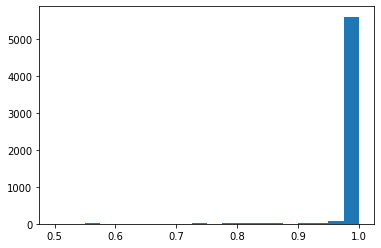

In [25]:
plt.hist(p_array[:,1], bins=np.linspace(0.5, 1.0, 21))

In [26]:
p_df = DataFrame([list(detection[0]) + list(detection[1]) for detection in detected_cell_list], columns=["row", "column", "p_not", "p"])
p_df = p_df[["row", "column", "p"]]
p_df["correct"] = is_correctly_detected

correct
False    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
True     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

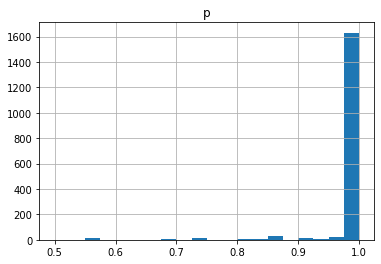

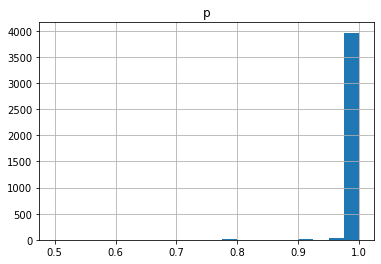

In [28]:
p_df[["correct","p"]].groupby("correct").hist(bins=np.linspace(0.5, 1.0, 21))

In [29]:
undetected_cell_list = list(d.undetected_cells.items())
probabilities = [detection[1] for detection in undetected_cell_list]
is_correctly_detected = [cell[0] not in actual_errors for cell in undetected_cell_list]

p_df_n = DataFrame([list(detection[0]) + list(detection[1]) for detection in undetected_cell_list], columns=["row", "column", "p_not", "p"])
p_df_n = p_df_n[["row", "column", "p"]]
p_df_n["correct"] = is_correctly_detected

correct
False    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
True     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

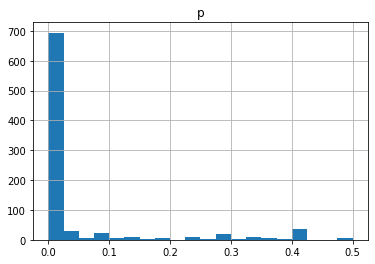

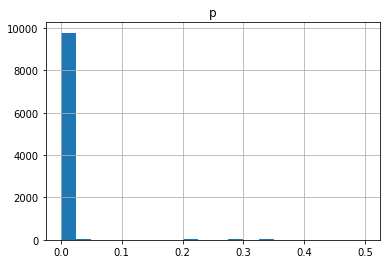

In [30]:
p_df_n[["correct","p"]].groupby("correct").hist(bins=np.linspace(0.0, 0.5, 21))

In [31]:
low_p = p_df[p_df["p"] < 0.60]

In [32]:
low_p.shape[0]

13

In [33]:
p_df.shape[0]

5803

In [34]:
low_p_dataframe = d.dataframe.loc[low_p["row"].unique(),:]

In [35]:
sum(d.extended_labeled_cells.values())


4005

In [36]:
correction_features = []

for cell in d.corrected_cells:
    correction_features.append(list(cell) +
                               [d.dataframe.iloc[cell]] +
                               [d.corrected_cells[cell]] +
                               [actual_errors[cell] if cell in actual_errors else d.dataframe.iloc[cell]] +
                               list(d.pair_features[cell][d.corrected_cells[cell]]))

In [37]:
correction_features_df = DataFrame(correction_features,
                                   columns=["row",
                                            "column",
                                            "old_value",
                                            "new_value",
                                            "actual_value",
                                            *[f"feature_value_{i}" for i in range(8)],
                                            *[f"feature_vicinity_{i}" for i in range(7)],
                                            "feature_domain"])

In [38]:
correction_features_df.iloc[:,5:].mean().sort_values()

feature_value_0       0.000396
feature_value_1       0.000396
feature_value_2       0.005046
feature_value_3       0.005046
feature_vicinity_1    0.008810
feature_value_5       0.011136
feature_vicinity_0    0.018621
feature_domain        0.019134
feature_value_7       0.021031
feature_value_4       0.032224
feature_vicinity_4    0.042789
feature_value_6       0.057344
feature_vicinity_5    0.200561
feature_vicinity_3    0.220696
feature_vicinity_6    0.301334
feature_vicinity_2    0.877990
dtype: float64

In [39]:
correction_features_df.iloc[:,[1] + list(range(5,correction_features_df.shape[1]))].groupby("column").mean()

,feature_value_0,feature_value_1,feature_value_2,feature_value_3,feature_value_4,feature_value_5,feature_value_6,feature_value_7,feature_vicinity_0,feature_vicinity_1,feature_vicinity_2,feature_vicinity_3,feature_vicinity_4,feature_vicinity_5,feature_vicinity_6,feature_domain
column,,,,,,,,,,,,,,,,
3,0.000000,0.000000,0.006485,0.006485,0.028436,0.011298,0.038608,0.016400,0.014218,0.006459,0.994945,0.000000,0.096367,0.142180,0.470379,0.018201
4,0.000000,0.000000,0.005990,0.005990,0.138822,0.041492,0.215029,0.062580,0.041162,0.033697,1.000000,0.530266,0.000000,0.460048,0.421308,0.058263
5,0.001063,0.001063,0.004642,0.004642,0.001063,0.000869,0.011373,0.007204,0.009564,0.002586,0.921216,0.085902,0.043571,0.000000,0.306924,0.010157
6,0.000000,0.000000,0.003332,0.003332,0.009311,0.005587,0.038714,0.018767,0.022346,0.003348,0.570548,0.478963,0.011173,0.421257,0.000000,0.005873


In [41]:
correction_features_df["wrong_correction"] = (correction_features_df["old_value"] == correction_features_df["actual_value"]) & (correction_features_df["old_value"] != correction_features_df["new_value"])

In [42]:
correction_features_df["wrong_correction"].sum() / correction_features_df.shape[0]

0.044770206022187

In [43]:
distinct_features = []

for column_index in range(d.dataframe.shape[1]):
    unique_rows = np.unique(d.column_features[column_index], axis=0)
    distinct_features.append(unique_rows.shape[0])

distinct_features

[1390, 114, 308, 288, 514, 393, 525]

In [44]:
cluster_features = []

for cluster_i in range(1,21):
    cluster_features.append(d.column_features[3][
        [key[0] for key in d.clusters_k_j_c_ce[21][3][cluster_i].keys()]])

In [45]:
cluster_feature_means = np.array([cluster.mean(axis=0) for cluster in cluster_features])

In [46]:
Series([len(cluster) for cluster in d.clusters_k_j_c_ce[21][3].values()]).value_counts().sort_index()

1      3
2      2
4      3
7      1
10     1
12     2
13     1
31     1
32     1
72     1
102    1
211    1
344    1
751    1
760    1
dtype: int64

In [47]:
df = d.correction_prediction_dfs[0][5]

In [48]:
df["prediction"].sum()

884

In [49]:
df["prediction"].groupby(df["cell"]).sum().sort_values()

cell
(5, 5)       0
(1987, 5)    0
(903, 5)     0
(1414, 5)    0
(388, 5)     0
(391, 5)     0
(1967, 5)    0
(1434, 5)    0
(879, 5)     0
(398, 5)     0
(1439, 5)    0
(1443, 5)    0
(1960, 5)    0
(1451, 5)    0
(1469, 5)    0
(870, 5)     0
(1944, 5)    0
(407, 5)     0
(1927, 5)    0
(1917, 5)    0
(1911, 5)    0
(1908, 5)    0
(1879, 5)    0
(1850, 5)    0
(863, 5)     0
(861, 5)     0
(1990, 5)    0
(851, 5)     0
(374, 5)     0
(2000, 5)    0
            ..
(796, 5)     1
(763, 5)     1
(765, 5)     1
(767, 5)     1
(768, 5)     1
(769, 5)     1
(771, 5)     1
(772, 5)     1
(774, 5)     1
(775, 5)     1
(776, 5)     1
(778, 5)     1
(780, 5)     1
(781, 5)     1
(782, 5)     1
(783, 5)     1
(784, 5)     1
(785, 5)     1
(786, 5)     1
(787, 5)     1
(788, 5)     1
(789, 5)     1
(790, 5)     1
(791, 5)     1
(792, 5)     1
(793, 5)     1
(794, 5)     1
(795, 5)     1
(761, 5)     1
(2318, 5)    1
Name: prediction, Length: 1057, dtype: int64

In [50]:
df = df[df["prediction"] == 1]

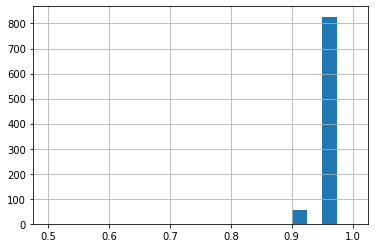

In [51]:
df["probability"].hist(bins=np.linspace(0.5, 1.0, 21))

In [52]:
aggregated = df.groupby("cell").agg({"prediction": "sum",
                                     "cell": "first",
                                     "probability": list,
                                     "correction": list})
aggregated = aggregated[aggregated["prediction"] == 2]
aggregated

,prediction,cell,probability,correction
cell,,,,


In [ ]:
# Compare correction and actual
cell = (59,5)
print(d.corrected_cells[cell])
print(actual_errors[cell])

In [53]:
confidence_list = list(d.correction_confidences.items())
is_correctly_detected = [cell_conf_tuple[0] in actual_errors for cell_conf_tuple in confidence_list]
is_correctly_corrected = [cell_conf_tuple[0] in actual_errors and
                          d.corrected_cells[cell_conf_tuple[0]] == actual_errors[cell_conf_tuple[0]]
                          for cell_conf_tuple in confidence_list]
correction_confidence_df = DataFrame({"cell": [item[0] for item in confidence_list],
                                      "confidence": [item[1] for item in confidence_list],
                                      "detection_correct": is_correctly_detected,
                                      "correct": is_correctly_corrected})
correction_confidence_df

,cell,confidence,detection_correct,correct
0,"(222, 3)",1.000000,True,True
1,"(572, 3)",1.000000,True,True
2,"(688, 3)",1.000000,True,True
3,"(1042, 3)",1.000000,True,True
4,"(1099, 3)",1.000000,True,True
5,"(1409, 3)",1.000000,True,True
6,"(1498, 3)",1.000000,True,True
7,"(2016, 3)",1.000000,True,True
8,"(2152, 3)",1.000000,True,True
9,"(54, 3)",1.000000,True,True


In [54]:
correction_confidence_df[correction_confidence_df["detection_correct"] & ~correction_confidence_df["correct"]]

,cell,confidence,detection_correct,correct
19,"(85, 3)",1.000000,True,False
58,"(188, 3)",1.000000,True,False
84,"(372, 3)",1.000000,True,False
123,"(475, 3)",1.000000,True,False
152,"(667, 3)",1.000000,True,False
175,"(753, 3)",1.000000,True,False
212,"(849, 3)",1.000000,True,False
241,"(1041, 3)",1.000000,True,False
255,"(1108, 3)",1.000000,True,False
291,"(1258, 3)",1.000000,True,False


In [57]:
d.correction_prediction_dfs[0][3][d.correction_prediction_dfs[0][3]["prediction"] == 1]

,cell,correction,prediction,probability
1419,"(54, 3)",8:41 a.m.,1,1.0
1463,"(55, 3)",7:45 p.m.,1,1.0
1507,"(56, 3)",3:27 p.m.,1,1.0
1540,"(58, 3)",11:25 a.m.,1,1.0
1639,"(60, 3)",11:25 p.m.,1,1.0
1859,"(67, 3)",8:15 a.m.,1,1.0
1947,"(69, 3)",4:15 p.m.,1,1.0
2122,"(73, 3)",2:55 p.m.,1,1.0
2519,"(82, 3)",7:53 a.m.,1,1.0
2607,"(84, 3)",11:45 a.m.,1,1.0


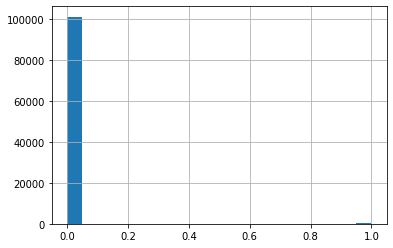

In [66]:
df = d.correction_prediction_dfs[15][3]
df["probability"].hist(bins=np.linspace(0.0, 1.0, 21))